# Tree Crown Segmentation from Canopy Height Model

This notebook contains simple workflow to extract individual tree crowns from a high‑resolution canopy height model (CHM) stored in NetCDF4 format.  

**Key steps**  
1. **Load CHM**  
   Reads `.nc4` file and extracts the canopy height array along with its spatial transform for later export.  
2. **Threshold & Clean**  
   Applies a user‑defined height cutoff to mask “tree” pixels, then removes small speckles and fills tiny holes to clean the binary tree mask.  
3. **Seed Detection**  
   Finds local maxima in the CHM (one per tree top) based on an approximate crown radius.  
4. **Watershed Segmentation**  
   Runs a marker‑based watershed on the inverted CHM so each seed grows into its own crown region.  
5. **Size Filtering**  
   Keeps only those segmented regions whose pixel area falls within a user‑specified range, discarding both tiny noise blobs and unrealistically large clumps.  
6. **Visualization**  
   Plots the original CHM next to the CHM with tree‑crown boundaries overlaid for easy comparison.  
7. **Shapefile Export**  
   Converts each final crown mask into vector polygons and writes them to a standard ESRI Shapefile for use in GIS.

> **User parameters** (in the next cell) let you specify:  
> - CHM input path & variable name  
> - Minimum canopy height to qualify as “tree”  
> - Minimum/maximum pixel area per crown  
> - Approximate crown radius (to space the watershed seeds)  


In [45]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from scipy.ndimage         import distance_transform_edt
from skimage.feature       import peak_local_max
from skimage.segmentation  import watershed, mark_boundaries, find_boundaries
from skimage.morphology    import remove_small_objects, remove_small_holes
from affine                import Affine
from rasterio.features     import shapes
from shapely.geometry      import shape
import geopandas as gpd

# === USER‑DEFINED PARAMETERS ===
INPUT_NC4    = "Cleaned_Data/canopy_height_eth.nc4"   # your CHM file
VAR_NAME     = "canopy_height_eth"                            # variable name inside the .nc4

HT_THRESH    = 20     # cm or m?: min canopy height to consider as “tree”
MIN_PIX      = 200     # px²: remove blobs smaller than this
MAX_PIX      = 3000    # px²: remove blobs larger than this
MIN_DIST     = 8       # px: approximate crown radius (controls seed spacing)

OUTPUT_SHP   = "simple_tree_crowns.shp"            # output shapefile path

# helper to load CHM and build geotransform
def load_chm(nc4_path, var_name):
    ds = xr.open_dataset(nc4_path)
    chm = ds[var_name].values.astype(float)
    dx = float(ds['x'][1] - ds['x'][0])
    dy = float(ds['y'][1] - ds['y'][0])
    x_min = float(ds['x'].min()) - dx/2
    y_max = float(ds['y'].max()) + dy/2
    transform = Affine.translation(x_min, y_max) * Affine.scale(dx, -dy)
    ds.close()
    return chm, transform

Final crowns: 847 components


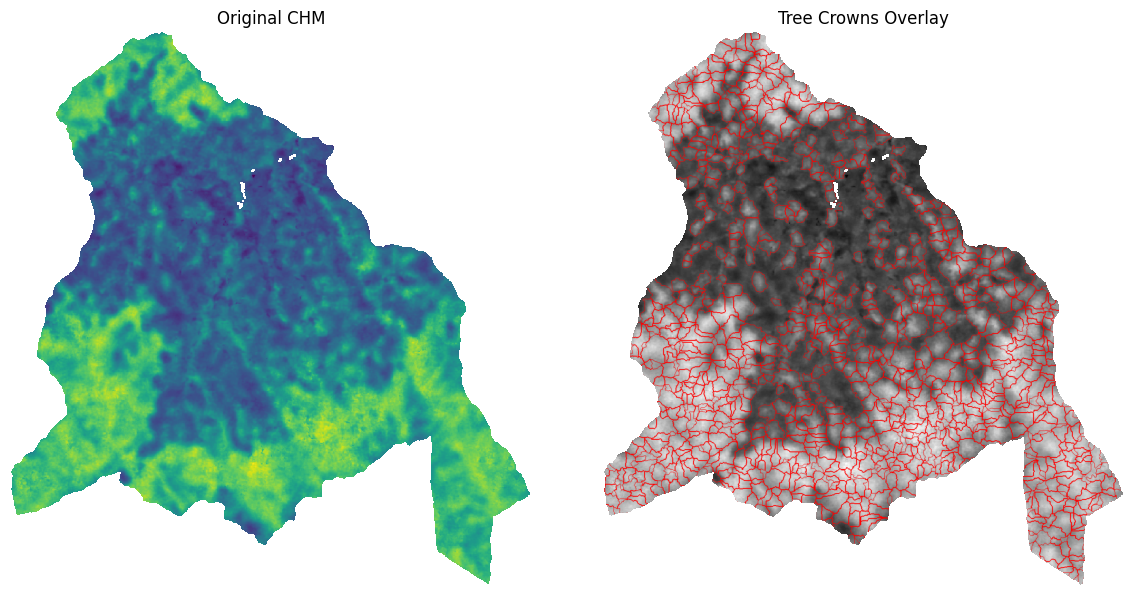

Wrote 847 polygons to simple_tree_crowns.shp


In [46]:
# run segmentation, show original vs overlay, and export

# 1) Load CHM & geotransform
chm, transform = load_chm(INPUT_NC4, VAR_NAME)

# 2) Create & clean binary mask
mask = chm > HT_THRESH
mask = remove_small_objects(mask, MIN_PIX)
mask = remove_small_holes(mask, MIN_PIX)

# 3) Seed detection & watershed
coords = peak_local_max(
    chm, min_distance=MIN_DIST, threshold_abs=HT_THRESH, labels=mask
)
markers = np.zeros(mask.shape, dtype=int)
for i,(r,c) in enumerate(coords, start=1):
    markers[r, c] = i
labels = watershed(-chm, markers, mask=mask)

# 4) Filter components by size
keep = np.zeros_like(labels)
next_lab = 1
for lab in np.unique(labels):
    if lab == 0: continue
    comp = labels == lab
    area = comp.sum()
    if MIN_PIX <= area <= MAX_PIX:
        keep[comp] = next_lab
        next_lab += 1
labels = keep
print(f"Final crowns: {labels.max()} components")

# 5) Plot: original CHM vs. overlay
chm_norm = (chm - np.nanmin(chm)) / (np.nanmax(chm) - np.nanmin(chm))
overlay = mark_boundaries(np.dstack([chm_norm]*3), labels, color=(1,0,0))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.imshow(chm_norm, cmap='viridis')
ax1.set_title("Original CHM")
ax1.axis('off')
ax2.imshow(overlay)
ax2.set_title("Tree Crowns Overlay")
ax2.axis('off')
plt.tight_layout()
plt.show()

# 6) Export to Shapefile
records = []
for lab in range(1, labels.max()+1):
    comp = (labels==lab).astype('uint8')
    for geom, val in shapes(comp, mask=comp, transform=transform):
        records.append({"geometry": shape(geom), "label": lab})
gdf = gpd.GeoDataFrame(records, crs="EPSG:4326")
gdf.to_file(OUTPUT_SHP)
print(f"Wrote {len(gdf)} polygons to {OUTPUT_SHP}")